In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa
import scipy
import os
from IPython.display import Audio
from scipy.signal import find_peaks
from scipy.signal import butter, sosfilt, sosfreqz
from scipy.integrate import simps
import bisect
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from scipy.fftpack import dct
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import scale

In [5]:
# Dictionary for audio data

Audiodata = {'percentile_25': [], 'percentile_50': [], 'percentile_75': [], 'percentile_90': [], 'label': []}
Audiodata_mfcc = {'mfcc': [], 'label': []}
Audiodata_combined = {'percentile_25': [], 'percentile_50': [], 'percentile_75': [], 'percentile_90': [], 'mfcc': [], 'label': []}

In [6]:
# Real Cough Timestamps of the Data

def get_real_timestamps(cough_timestamp):

    timestamp = []
    f = open(cough_timestamp, "r")
    content = f.read()
    content = content.split("\n")

    for line in content:
        if line != "":
            timestamp.append(float(line.split("\t")[0]))
    
    return timestamp

In [7]:
# Filtering of the data

def butter_bandpass(lowcut, highcut, fs, order=5):
        nyq = 0.5 * fs
        low = lowcut / nyq
        high = highcut / nyq
        sos = butter(order, [low, high], analog=False, btype='band', output='sos')
        return sos

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
        sos = butter_bandpass(lowcut, highcut, fs, order=order)
        y = sosfilt(sos, data)
        return y

In [8]:
# Data Normalization

def normalize_data(data):
    min = np.min(data)
    max = np.max(data)

    data = (data - min) / (max - min)
    return data

In [9]:
# Moving Average of the Data

def compute_moving_average(data, window_size=15):
    
    moving_averages = []

    i = 0
    while i < len(data) - window_size + 1:
        
        window = data[i : i + window_size]
        window_average = round(np.sum(window) / window_size, 2)
        moving_averages.append(window_average)

        i += 1    
    
    return np.array(moving_averages)

In [10]:
def binary_search(auc_values, threshold):
    index = bisect.bisect_left(auc_values, threshold)
    if index < len(auc_values):
        return index
    return None

In [11]:
# Percentile Points of a Signal

def find_percentile_points(signal):
    
        # Calculating Fast Fourier Transform
        X = np.fft.fft(signal)
        X_mag = np.abs(X) / len(signal)

        freqs = np.fft.fftfreq(len(signal), d=1/sample_rate)

        # Graph
        positive_freq_indices = np.where(freqs >= 0)

        # Getting positive part
        freqs = freqs[positive_freq_indices]
        X_mag = X_mag[positive_freq_indices]

        auc = simps(X_mag, freqs)
        per_25 = auc * 0.25
        per_50 = auc * 0.50
        per_75 = auc * 0.75
        per_90 = auc * 0.90

        # Cumulative area
        cumulative_auc = [simps(X_mag[:i+1], freqs[:i+1]) for i in range(len(freqs))]

        # Find the indices for each percentile
        point_1 = binary_search(cumulative_auc, per_25)
        point_2 = binary_search(cumulative_auc, per_50)
        point_3 = binary_search(cumulative_auc, per_75)
        point_4 = binary_search(cumulative_auc, per_90)

        per_25_result = freqs[point_1]
        per_50_result = freqs[point_2]
        per_75_result = freqs[point_3]
        per_90_result = freqs[point_4]
        
        return per_25_result, per_50_result, per_75_result, per_90_result

In [12]:
# MFCC values of a Signal

def get_mfcc_features(signal):
        
    # Original MFCCs
    mfccs = librosa.feature.mfcc(y=signal, sr=sample_rate, n_mfcc=13)


    # First derivative of MFCCs
    delta_mfccs = librosa.feature.delta(mfccs)


    # Second derivative of MFCCs
    delta2_mfccs = librosa.feature.delta(mfccs, order=2)
    
    return mfccs, delta_mfccs, delta2_mfccs

In [13]:
def calculate_split_frequency_bin(spectrogram, split_frequency, sample_rate):
    
    frequency_range = sample_rate / 2
    frequency_delta_per_bin = frequency_range / spectrogram.shape[0]
    split_frequency_bin = np.floor(split_frequency / frequency_delta_per_bin)
    
    return int(split_frequency_bin)

In [14]:
def calculate_band_energy_ratio(spectrogram, split_frequency, sample_rate):
    split_frequency_bin = calculate_split_frequency_bin(spectrogram, split_frequency, sample_rate)
    
    # move to the power spectrogram
    power_spec = np.abs(spectrogram) ** 2
    
    

In [15]:
# Cough Audio Percentile Calculation

audio_files = os.listdir('../audio-records/cough')
timestamp_files = os.listdir('../audio-records/cough-timestamps')
all_timestamp_data = dict()

per_25_data = []
per_50_data = []
per_75_data = []
per_90_data = []

# Filtering irrelevant files
audio_files = list(filter(lambda x: x.endswith('.wav'), audio_files))
timestamp_files = list(filter(lambda x: x.endswith('.txt'), timestamp_files))
# Getting cough detection results
for file in audio_files:

    file_name = file.split(".wav")[0]    
    timestamp_files = [file[0:19] for file in timestamp_files]    

    # Finding correspoding timestamp file
    index = timestamp_files.index(file_name)
    timestamp_data = timestamp_files[index]
    
    file_path = '../audio-records/cough/' + file
    timestamp_path = '../audio-records/cough-timestamps/' + timestamp_data + '-label.txt'

    # Adding timestamps to the list
    real_timestamps = get_real_timestamps(timestamp_path)    
    
    # Loading audio_file
    # Target sample rate: 48000
    data, sample_rate = librosa.load(file_path, sr=48000)

    # Audio duration
    duration = librosa.get_duration(path = file_path)
    total_samples = duration * sample_rate
    time = np.arange(0, len(data)) / sample_rate

    # Filtering data
    data = butter_bandpass_filter(data, 1000, 4000, sample_rate,8)

    # Getting moving average of the data
    moving_avg_data = compute_moving_average(np.abs(data))

    # Normalize the data
    moving_avg_data = normalize_data(moving_avg_data)
    
    
    # *******************************
    # Find coughs in the data
    copy_data = moving_avg_data.copy()
    coughs = []

    for timestamp in real_timestamps:

        start = int((timestamp - 0.2) * sample_rate)
        finish = int((timestamp + 0.2) * sample_rate)

        data = copy_data[start:finish]
        coughs.append(data)

    
    # *******************************
    # Find percentile points
    for cough in coughs:
        # Removing DC component
        cough -= np.mean(cough)

        per_25, per_50, per_75, per_90 = find_percentile_points(cough)
        
        per_25_data.append(per_25)
        per_50_data.append(per_50)
        per_75_data.append(per_75)
        per_90_data.append(per_90)

        Audiodata['percentile_25'].append(per_25)
        Audiodata['percentile_50'].append(per_50)
        Audiodata['percentile_75'].append(per_75)
        Audiodata['percentile_90'].append(per_90)
        Audiodata['label'].append('cough')
        
        
        # For combined
        Audiodata_combined['percentile_25'].append(per_25)
        Audiodata_combined['percentile_50'].append(per_50)
        Audiodata_combined['percentile_75'].append(per_75)
        Audiodata_combined['percentile_90'].append(per_90)
        Audiodata_combined['label'].append('cough')
        
        # *******************************
        # MFCC Feature extraction

        mfccs, delta_mfccs, delta2_mfccs = get_mfcc_features(cough)
        
        # Comprehensive MFCCs
        comprehensive_mfccs = np.concatenate((mfccs, delta_mfccs, delta2_mfccs))
        Audiodata_mfcc['mfcc'].append(comprehensive_mfccs)
        Audiodata_mfcc['label'].append('cough')
        
        Audiodata_combined['mfcc'].append(comprehensive_mfccs)

In [16]:
# No Cough Audio Percentile Calculation
audio_files = os.listdir('../audio-records/no-cough')
timestamp_files = os.listdir('../audio-records/no-cough-timestamps')
all_timestamp_data = dict()

no_cough_per_25_data = []
no_cough_per_50_data = []
no_cough_per_75_data = []
no_cough_per_90_data = []
no_cough_mfccs = []

# Filtering irrelevant files
audio_files = list(filter(lambda x: x.endswith('.wav'), audio_files))
timestamp_files = list(filter(lambda x: x.endswith('.txt'), timestamp_files))
# Getting cough detection results
for file in audio_files:

    file_name = file.split(".wav")[0]    
    timestamp_files = [file[0:19] for file in timestamp_files]    

    # Finding correspoding timestamp file
    index = timestamp_files.index(file_name)
    timestamp_data = timestamp_files[index]
    
    file_path = '../audio-records/no-cough/' + file
    timestamp_path = '../audio-records/no-cough-timestamps/' + timestamp_data + '-label.txt'
    
    # Adding timestamps to the list
    real_timestamps = get_real_timestamps(timestamp_path)    
    
    # Loading audio_file
    # Target sample rate: 48000
    data, sample_rate = librosa.load(file_path, sr=48000)

    # Audio duration
    duration = librosa.get_duration(path = file_path)
    total_samples = duration * sample_rate
    time = np.arange(0, len(data)) / sample_rate

    # Filtering data
    data = butter_bandpass_filter(data, 1000, 4000, sample_rate,8)

    # Getting moving average of the data
    moving_avg_data = compute_moving_average(np.abs(data))

    # Normalize the data
    moving_avg_data = normalize_data(moving_avg_data)
    
    # *******************************
    # Find coughs in the data
    copy_data = moving_avg_data.copy()
    peaks = []

    for timestamp in real_timestamps:

        start = int((timestamp - 0.2) * sample_rate)
        finish = int((timestamp + 0.2) * sample_rate)
        
        if (start < 0):
            start = 0
        
        data = copy_data[start:finish]
        peaks.append(data)
    # *******************************
    
    # *******************************
    # Find percentile points
    for peak in peaks:
        # Removing DC component
        peak -= np.mean(peak)
        
        no_cough_per_25, no_cough_per_50, no_cough_per_75, no_cough_per_90 = find_percentile_points(peak)
        
        no_cough_per_25_data.append(no_cough_per_25)
        no_cough_per_50_data.append(no_cough_per_50)
        no_cough_per_75_data.append(no_cough_per_75)
        no_cough_per_90_data.append(no_cough_per_90)
        
        Audiodata['percentile_25'].append(no_cough_per_25)
        Audiodata['percentile_50'].append(no_cough_per_50)
        Audiodata['percentile_75'].append(no_cough_per_75)
        Audiodata['percentile_90'].append(no_cough_per_90)
        Audiodata['label'].append('other')
        
        Audiodata_combined['percentile_25'].append(no_cough_per_25)
        Audiodata_combined['percentile_50'].append(no_cough_per_50)
        Audiodata_combined['percentile_75'].append(no_cough_per_75)
        Audiodata_combined['percentile_90'].append(no_cough_per_90)
        Audiodata_combined['label'].append('other')
        
        # *******************************
    
        # MFCC Feature extraction

        mfccs, delta_mfccs, delta2_mfccs = get_mfcc_features(peak)
 
        # Comprehensive MFCCs
        comprehensive_mfccs = np.concatenate((mfccs, delta_mfccs, delta2_mfccs))
        Audiodata_mfcc['mfcc'].append(comprehensive_mfccs)
        Audiodata_mfcc['label'].append('other')

        Audiodata_combined['mfcc'].append(comprehensive_mfccs)

# Percentile Graphs

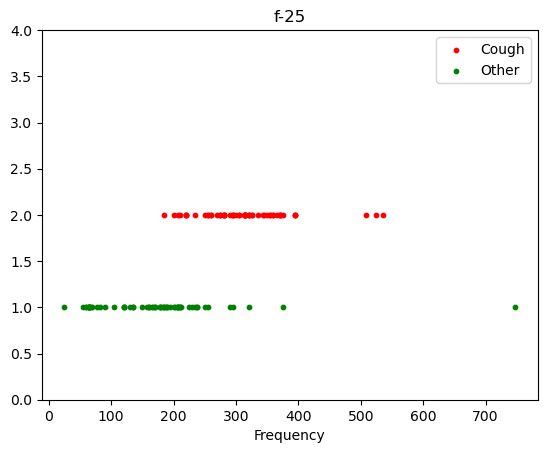

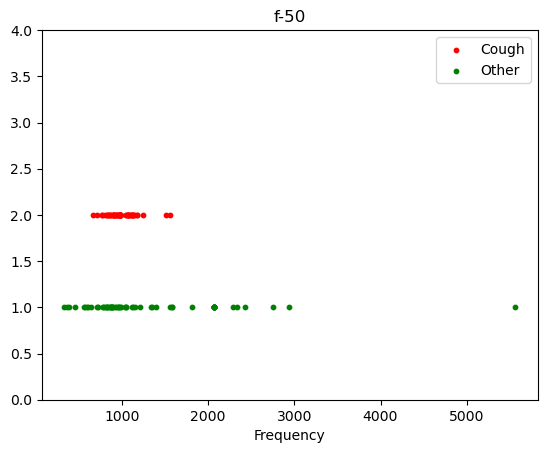

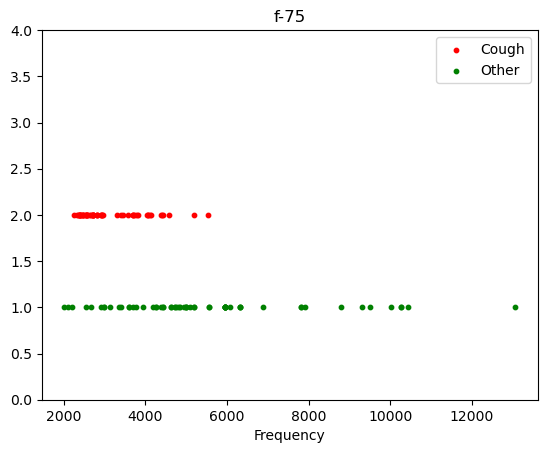

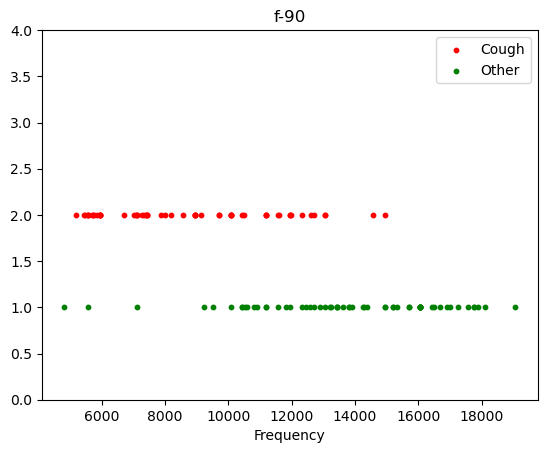

In [17]:
# PLOT OF COUGH AND NO COUGH

# 25 percentile

# Cough
i = 0
for point in per_25_data:
    
    if i == 0:
        plt.scatter(point, 2, marker='o', color='red', s=10, zorder=5, label='Cough')

    else: 
        plt.scatter(point, 2, marker='o', color='red', s=10, zorder=5)

    i += 1
    
# No Cough
i = 0
for point in no_cough_per_25_data:
    
    if i == 0:
        plt.scatter(point, 1, marker='o', color='green', s=10, zorder=5, label='Other')
        
    else: 
        plt.scatter(point, 1, marker='o', color='green', s=10, zorder=5)

    i += 1

plt.title("f-25")
plt.xlabel("Frequency")
plt.legend()
plt.ylim(0, 4)
plt.show()

# 50 percentile 

# Cough

i = 0
for point in per_50_data:
    
    if i == 0:
        plt.scatter(point, 2, marker='o', color='red', s=10, zorder=5, label='Cough')

    else: 
        plt.scatter(point, 2, marker='o', color='red', s=10, zorder=5)

    i += 1
    
    
# No Cough

i = 0
for point in no_cough_per_50_data:
    
    if i == 0:
        plt.scatter(point, 1, marker='o', color='green', s=10, zorder=5, label='Other')

    else: 
        plt.scatter(point, 1, marker='o', color='green', s=10, zorder=5)
        
    i += 1
    
    
plt.title("f-50")
plt.xlabel("Frequency")
plt.legend()
plt.ylim(0, 4)
plt.show()


# 75 percentile

# Cough

i = 0
for point in per_75_data:
    
    if i == 0:
        plt.scatter(point, 2, marker='o', color='red', s=10, zorder=5, label='Cough')

    else: 
        plt.scatter(point, 2, marker='o', color='red', s=10, zorder=5)
        
    i += 1
    

# No Cough

i = 0
for point in no_cough_per_75_data:
    
    if i == 0:
        plt.scatter(point, 1, marker='o', color='green', s=10, zorder=5, label='Other')

    else: 
        plt.scatter(point, 1, marker='o', color='green', s=10, zorder=5)

    i += 1

plt.title("f-75")
plt.xlabel("Frequency")
plt.legend()
plt.ylim(0, 4)
plt.show()
# 90 percentile

# Cough

i = 0
for point in per_90_data:
    
    if i == 0:
        plt.scatter(point, 2, marker='o', color='red', s=10, zorder=5, label='Cough')

    else: 
        plt.scatter(point, 2, marker='o', color='red', s=10, zorder=5)

    i += 1
    
# No Cough

i = 0
for point in no_cough_per_90_data:
    
    if i == 0:
        plt.scatter(point, 1, marker='o', color='green', s=10, zorder=5, label='Other')

    else: 
        plt.scatter(point, 1, marker='o', color='green', s=10, zorder=5)

    i += 1
    
plt.title("f-90")
plt.xlabel("Frequency")
plt.legend()
plt.ylim(0, 4)
plt.show()

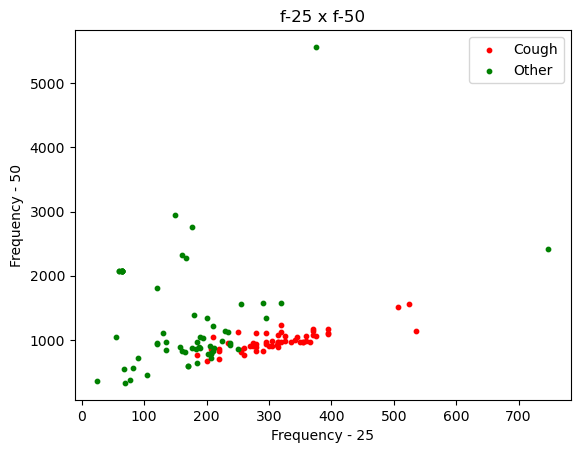

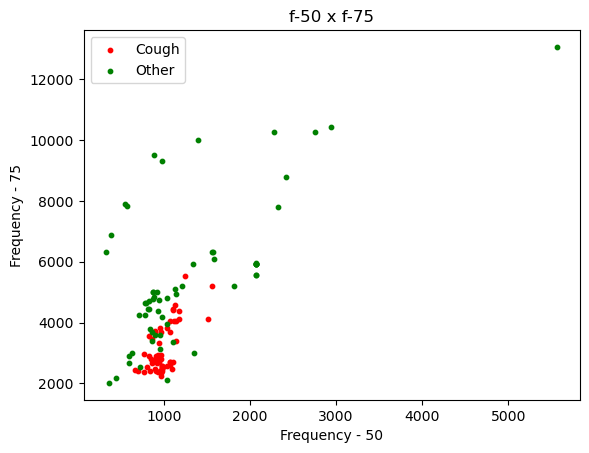

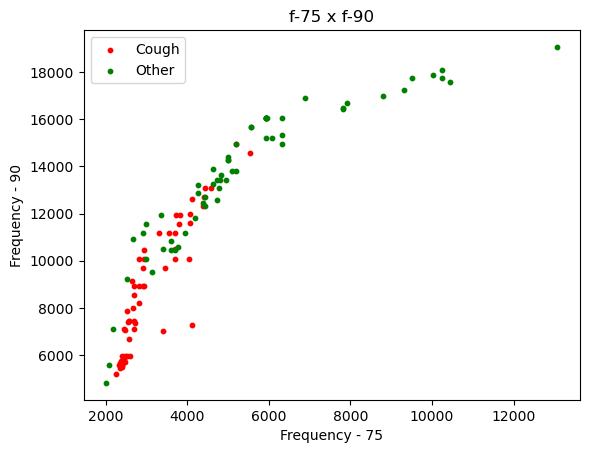

In [18]:
# 2 Dimensional Graphs


# 25 percentile x 50 percentile

# Cough
i = 0
for point1, point2 in zip(per_25_data, per_50_data):
    
    if i == 0:
        plt.scatter(point1, point2, marker='o', color='red', s=10, zorder=5, label='Cough')

    else: 
        plt.scatter(point1, point2, marker='o', color='red', s=10, zorder=5)

    i += 1
    
# No Cough
i = 0
for point1, point2 in zip(no_cough_per_25_data, no_cough_per_50_data):
    
    if i == 0:
        plt.scatter(point1, point2, marker='o', color='green', s=10, zorder=5, label='Other')
        
    else: 
        plt.scatter(point1, point2, marker='o', color='green', s=10, zorder=5)

    i += 1

plt.title("f-25 x f-50")
plt.xlabel("Frequency - 25")
plt.ylabel("Frequency - 50")
plt.legend()
plt.show()


# 50 percentile x 75 percentile

# Cough
i = 0
for point1, point2 in zip(per_50_data, per_75_data):
    
    if i == 0:
        plt.scatter(point1, point2, marker='o', color='red', s=10, zorder=5, label='Cough')

    else: 
        plt.scatter(point1, point2, marker='o', color='red', s=10, zorder=5)

    i += 1
    
# No Cough
i = 0
for point1, point2 in zip(no_cough_per_50_data, no_cough_per_75_data):
    
    if i == 0:
        plt.scatter(point1, point2, marker='o', color='green', s=10, zorder=5, label='Other')
        
    else: 
        plt.scatter(point1, point2, marker='o', color='green', s=10, zorder=5)

    i += 1

plt.title("f-50 x f-75")
plt.xlabel("Frequency - 50")
plt.ylabel("Frequency - 75")
plt.legend()
plt.show()

# 75 percentile x 90 percentile

# Cough
i = 0
for point1, point2 in zip(per_75_data, per_90_data):
    
    if i == 0:
        plt.scatter(point1, point2, marker='o', color='red', s=10, zorder=5, label='Cough')

    else: 
        plt.scatter(point1, point2, marker='o', color='red', s=10, zorder=5)

    i += 1
    
# No Cough
i = 0
for point1, point2 in zip(no_cough_per_75_data, no_cough_per_90_data):
    
    if i == 0:
        plt.scatter(point1, point2, marker='o', color='green', s=10, zorder=5, label='Other')
        
    else: 
        plt.scatter(point1, point2, marker='o', color='green', s=10, zorder=5)

    i += 1

plt.title("f-75 x f-90")
plt.xlabel("Frequency - 75")
plt.ylabel("Frequency - 90")
plt.legend()
plt.show()

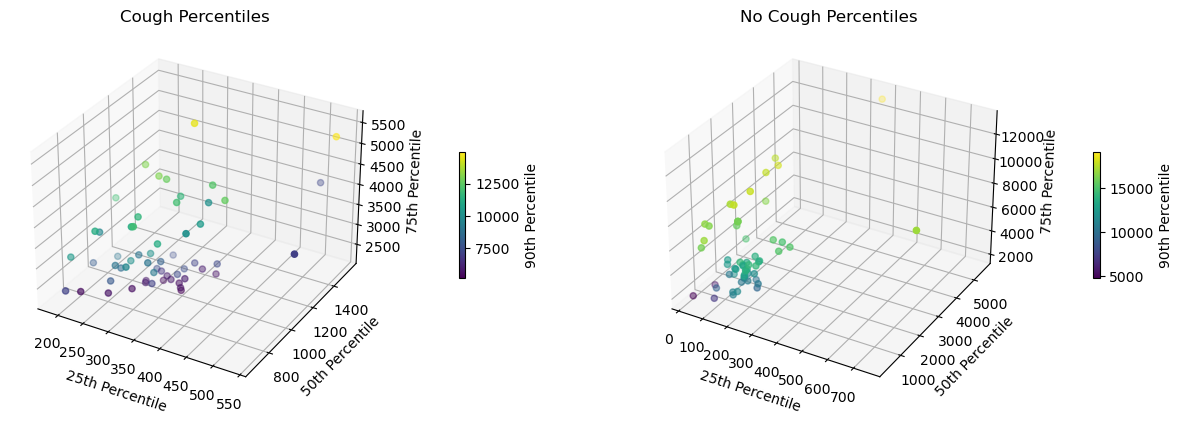

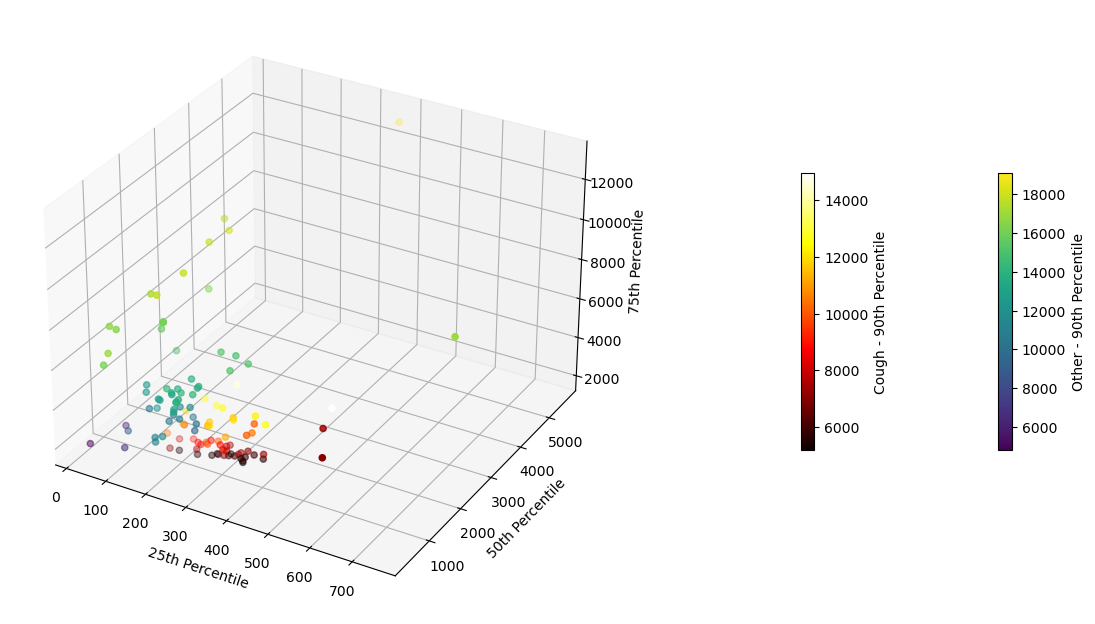

In [19]:
# 4 Dimensional Graph

# Cough Graph
fig = plt.figure(figsize=(15, 12))
ax = fig.add_subplot(221, projection='3d')

img = ax.scatter(per_25_data, per_50_data, per_75_data, c= per_90_data)
ax.set_xlabel('25th Percentile')
ax.set_ylabel('50th Percentile')
ax.set_zlabel('75th Percentile')
colorbar = fig.colorbar(img, shrink=0.3, pad=0.15)
colorbar.set_label('90th Percentile')
plt.title("Cough Percentiles")


# No Cough Graph

ax = fig.add_subplot(222, projection='3d')

img = ax.scatter(no_cough_per_25_data, no_cough_per_50_data, no_cough_per_75_data, c= no_cough_per_90_data, cmap='viridis')
ax.set_xlabel('25th Percentile')
ax.set_ylabel('50th Percentile')
ax.set_zlabel('75th Percentile')
colorbar.set_label('90th Percentile')
colorbar = fig.colorbar(img, shrink=0.3, pad=0.15)
colorbar.set_label('90th Percentile')
plt.title("No Cough Percentiles")
plt.show()

# Combinations

fig = plt.figure(figsize=(15, 12))
ax = fig.add_subplot(111, projection='3d')

img_1 = ax.scatter(no_cough_per_25_data, no_cough_per_50_data, no_cough_per_75_data, c= no_cough_per_90_data, cmap='viridis')
colorbar_1 = fig.colorbar(img_1, ax=[ax], shrink=0.3)
colorbar_1.set_label('Other - 90th Percentile')


img_2 = ax.scatter(per_25_data, per_50_data, per_75_data, c= per_90_data, cmap=plt.hot())
colorbar_2 = fig.colorbar(img_2, ax=[ax], shrink=0.3, pad=0.20)

ax.set_xlabel('25th Percentile')
ax.set_ylabel('50th Percentile')
ax.set_zlabel('75th Percentile')
colorbar_2.set_label('Cough - 90th Percentile')

plt.show()

# K-Nearest Neighbors

## KNN Percentiles

In [20]:
# Converting the Audiodata dictionary to pandas dataframe
df = pd.DataFrame.from_dict(Audiodata)

print(df.head())

   percentile_25  percentile_50  percentile_75  percentile_90  label
0          305.0          980.0         2575.0         7440.0  cough
1          315.0          970.0         2815.0         8190.0  cough
2          290.0          835.0         2400.0         5565.0  cough
3          275.0          900.0         3700.0        11190.0  cough
4          280.0          895.0         3735.0        11940.0  cough


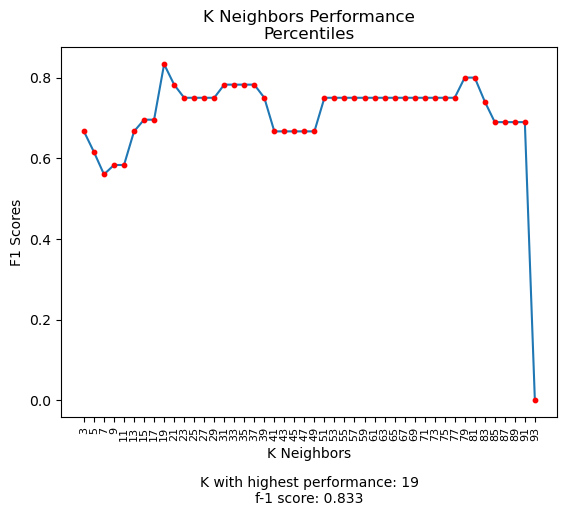


F1_score: 0.833


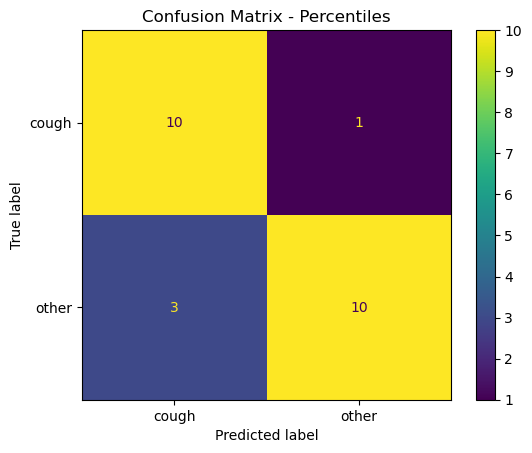

In [234]:
# file_labels include the file name, percentile and labels of the audio record
# Labels are cough or other
# Data is split as train data and test data

X = df.iloc[:, :4]
y = df.iloc[:, 4:5]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state= 3, test_size= 0.2)

y_train = np.ravel(y_train)
y_test = np.ravel(y_test)

# Define the model

K = 3 # Initial value of K
max_K = len(X_train)

k_values = []
f1_scores = []

while K < max_K:
    classifier = KNeighborsClassifier(K, p=2, metric='euclidean')
    classifier.fit(X_train, y_train)

    # Predict the test set results
    y_pred = classifier.predict(X_test)

    # F1 score
    f1 = f1_score(y_test, y_pred, pos_label='cough')
    
    k_values.append(K)
    f1_scores.append(f1)

    K += 2
    
index = f1_scores.index(np.max(f1_scores))
best_k_value = k_values[index]

plt.plot(k_values, f1_scores)
plt.xlabel('K Neighbors')
plt.ylabel('F1 Scores')
plt.title('K Neighbors Performance\nPercentiles')
plt.xticks(k_values, rotation=90, fontsize=8)
for k, f1 in zip(k_values, f1_scores):   
    plt.scatter(k, f1, marker='o', color='red', s=10, zorder=5)

plt.text(0.5, -0.2, 'K with highest performance: ' + str(best_k_value) + "\nf-1 score: " + str(round(np.max(f1_scores),3)) , horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)

plt.show()

# Evaluate Model

classifier = KNeighborsClassifier(n_neighbors=best_k_value, p=2, metric='euclidean')
classifier.fit(X_train, y_train)

# Predict the test set results

y_pred = classifier.predict(X_test)


cm = confusion_matrix(y_test, y_pred)
f1 = f1_score(y_test, y_pred, pos_label='cough')
print("\nF1_score: " + str(round(f1,3)))

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classifier.classes_)
disp.plot()
plt.title("Confusion Matrix - Percentiles")
plt.show()

# [[tp, fp]
# [fn, tn]]

## KNN MFCCs

In [242]:
# Preprocessing MFCC matrices before training the model
i = 0
for row in Audiodata_mfcc['mfcc']:
    
    Audiodata_mfcc['mfcc'][i] = row.flatten()
    
    i += 1

# Converting the Audiodata_mfcc dictionary to pandas dataframe

df_2 = pd.DataFrame.from_dict(Audiodata_mfcc)

print(df_2.head())

                                                mfcc  label
0  [-356.39807589073223, -424.07034764773715, -67...  cough
1  [-361.44165227976464, -429.1139240367695, -713...  cough
2  [-340.7079535361824, -408.3802252931873, -660....  cough
3  [-290.55393105996075, -342.0095732729152, -391...  cough
4  [-269.6123629591486, -269.43166397680045, -326...  cough


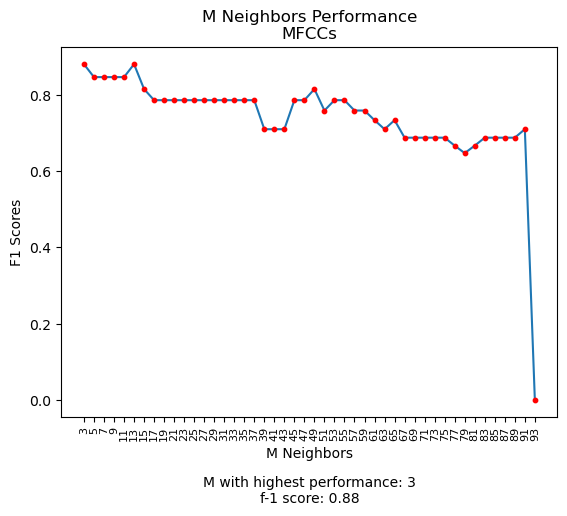


F1_score: 0.88


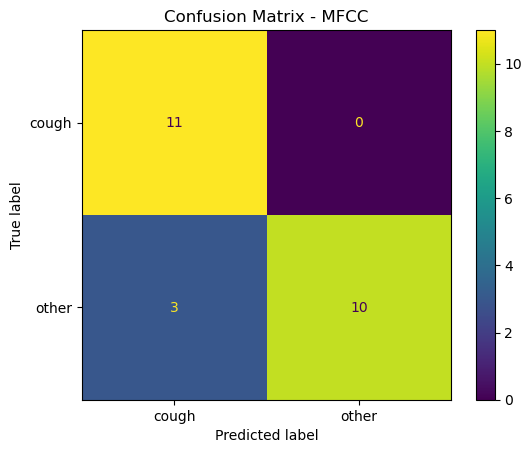

In [236]:
# file_labels include the file name, percentile and labels of the audio record
# Labels are cough or other
# Data is split as train data and test data

X_2 = df_2.iloc[:, :1]
X_2 = np.array(df_2['mfcc'].tolist())

y_2 = df_2.iloc[:, 1:2]

X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2, y_2, random_state= 3, test_size= 0.2)

y_train_2 = np.ravel(y_train_2)
y_test_2 = np.ravel(y_test_2)

# Define the model

M = 3 # Initial value of M
max_M = len(y_train_2)

m_values = []
f1_scores_mfcc = []

while M < max_M:
    classifier_mfcc = KNeighborsClassifier(M, p=2, metric='euclidean')
    classifier_mfcc.fit(X_train_2, y_train_2)

    # Predict the test set results

    y_pred_2 = classifier_mfcc.predict(X_test_2)

    # F1 score
    f1 = f1_score(y_test_2, y_pred_2, pos_label='cough')
    
    m_values.append(M)
    f1_scores_mfcc.append(f1)

    M += 2
    
index = f1_scores_mfcc.index(np.max(f1_scores_mfcc))
best_m_value = m_values[index]

plt.plot(m_values, f1_scores_mfcc)
plt.xlabel('M Neighbors')
plt.ylabel('F1 Scores')
plt.title('M Neighbors Performance\nMFCCs')
plt.xticks(m_values, rotation=90, fontsize=8)
for m, f1 in zip(m_values, f1_scores_mfcc):   
    plt.scatter(m, f1, marker='o', color='red', s=10, zorder=5)

plt.text(0.5, -0.2, 'M with highest performance: ' + str(best_m_value) + "\nf-1 score: " + str(round(np.max(f1_scores_mfcc),3)), horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)

plt.show()

# Evaluate Model

classifier_mfcc = KNeighborsClassifier(n_neighbors=best_m_value, p=2, metric='euclidean')
classifier_mfcc.fit(X_train_2, y_train_2)

# Predict the test set results

y_pred_2 = classifier_mfcc.predict(X_test_2)


cm_2 = confusion_matrix(y_test_2, y_pred_2)
f1_2 = f1_score(y_test_2, y_pred_2, pos_label='cough')
print("\nF1_score: " + str(round(f1_2,3)))

disp = ConfusionMatrixDisplay(confusion_matrix=cm_2, display_labels=classifier_mfcc.classes_)
disp.plot()
plt.title("Confusion Matrix - MFCC")
plt.show()


## KNN MFCCs and Percentiles

In [237]:
# Combined model

# Preprocessing MFCC matrices before training the model
i = 0
for row in Audiodata_combined['mfcc']:
    
    Audiodata_combined['mfcc'][i] = row.flatten()
    
    i += 1

# Converting the Audiodata_mfcc dictionary to pandas dataframe
df_3 = pd.DataFrame.from_dict(Audiodata_combined)

print(df_3.head())

   percentile_25  percentile_50  percentile_75  percentile_90  \
0          305.0          980.0         2575.0         7440.0   
1          315.0          970.0         2815.0         8190.0   
2          290.0          835.0         2400.0         5565.0   
3          275.0          900.0         3700.0        11190.0   
4          280.0          895.0         3735.0        11940.0   

                                                mfcc  label  
0  [-356.39807589073223, -424.07034764773715, -67...  cough  
1  [-361.44165227976464, -429.1139240367695, -713...  cough  
2  [-340.7079535361824, -408.3802252931873, -660....  cough  
3  [-290.55393105996075, -342.0095732729152, -391...  cough  
4  [-269.6123629591486, -269.43166397680045, -326...  cough  


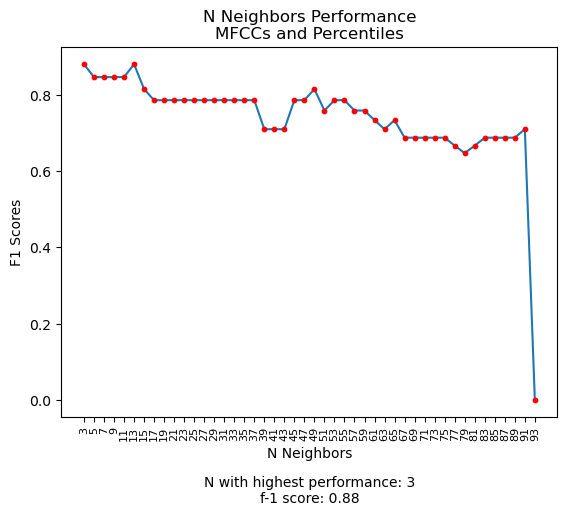


F1_score: 0.88


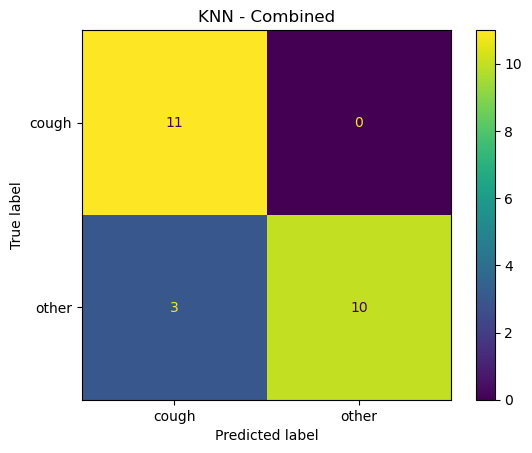

In [238]:
# file_labels include the file name, percentile and labels of the audio record
# Labels are cough or other
# Data is split as train data and test data

X_3 = df_3.iloc[:, :5]
y_3 = df_3.iloc[:, 5:6]

X_3 = np.array(df_3['mfcc'].tolist())

X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(X_3, y_3, random_state= 3, test_size= 0.2)

y_train_3 = np.ravel(y_train_3)
y_test_3 = np.ravel(y_test_3)

# Define the model

N = 3 # Initial value of K
max_N = len(y_train_3)

n_values = []
f1_scores_combined = []

while N < max_N:
    classifier_combined = KNeighborsClassifier(N, p=2, metric='euclidean')
    classifier_combined.fit(X_train_3, y_train_3)

    # Predict the test set results

    y_pred_3 = classifier_combined.predict(X_test_3)

    # F1 score
    f1_3 = f1_score(y_test_3, y_pred_3, pos_label='cough')
    
    n_values.append(N)
    f1_scores_combined.append(f1_3)

    N += 2
    
index = f1_scores_combined.index(np.max(f1_scores_combined))
best_n_value = n_values[index]

plt.plot(n_values, f1_scores_combined)
plt.xlabel('N Neighbors')
plt.ylabel('F1 Scores')
plt.title('N Neighbors Performance\nMFCCs and Percentiles')
plt.xticks(n_values, rotation=90, fontsize=8)
for n, f1 in zip(n_values, f1_scores_combined):   
    plt.scatter(n, f1, marker='o', color='red', s=10, zorder=5)

plt.text(0.5, -0.2, 'N with highest performance: ' + str(best_n_value) + "\nf-1 score: " + str(round(np.max(f1_scores_combined),3)), horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)

plt.show()

# Evaluate Model

classifier_combined = KNeighborsClassifier(n_neighbors=best_n_value, p=2, metric='euclidean')
classifier_combined.fit(X_train_3, y_train_3)

# Predict the test set results

y_pred_3 = classifier_combined.predict(X_test_3)


cm_3 = confusion_matrix(y_test_3, y_pred_3)
f1_3 = f1_score(y_test_3, y_pred_3, pos_label='cough')
print("\nF1_score: " + str(round(f1_3,3)))

disp = ConfusionMatrixDisplay(confusion_matrix=cm_3, display_labels=classifier_combined.classes_)
disp.plot()
plt.title("KNN - Combined")
plt.show()

# Support Vector Machine

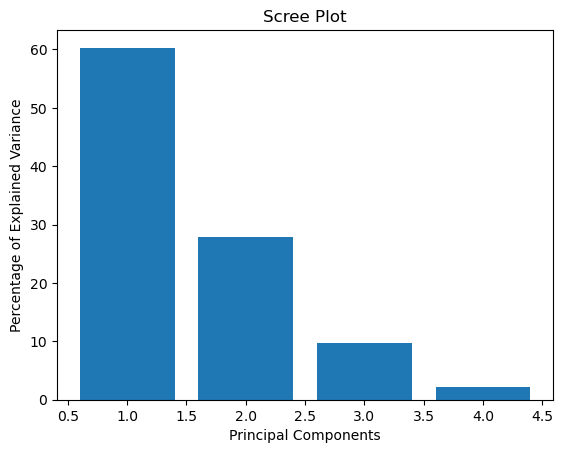

        var    PC
0  0.602633   PC1
1  0.278800   PC2
2  0.097724    PC
3  0.020843   PC4


In [229]:
# Support Vector Machine Data Preparation - Percentiles
df_svm_per = df.copy()

X_svm_per = df_svm_per.iloc[:, :4]
y_svm_per = df_svm_per.iloc[:, 4:5]

X_train_svm_per, X_test_svm_per, y_train_svm_per, y_test_svm_per = train_test_split(X_svm_per, y_svm_per, random_state= 3, test_size= 0.2)

y_train_svm_per = np.ravel(y_train_svm_per)
y_test_svm_per = np.ravel(y_test_svm_per)

y_train_svm_per = (y_train_svm_per == 'cough').astype(int)
y_test_svm_per = (y_test_svm_per == 'cough').astype(int)

X_train_scaled_per = scale(X_train_svm_per)
X_test_scaled_per = scale(X_test_svm_per)


# PCA: Principle Component Analysis
# For combining 4 features into 2 orthogonal meta-features

pca = PCA()

X_train_pca_per = pca.fit_transform(X_train_scaled_per)
per_var = np.round(pca.explained_variance_ratio_* 100, decimals=1)
labels = [str(x) for x in range(1, len(per_var)+1)]

plt.bar(x=range(1,len(per_var)+1), height=per_var)
plt.tick_params(
    axis='x',
    which='both',
    top=False,)

plt.ylabel('Percentage of Explained Variance')
plt.xlabel('Principal Components')
plt.title('Scree Plot')

plt.show()

df_sns = pd. DataFrame({ 'var':pca.explained_variance_ratio_,
'PC' : [' PC1', 'PC2', 'PC', 'PC4']})

print(df_sns.head())
        

In [204]:
# Train pc1 and pc2 coords
train_pc1_coords = X_train_pca_per[:, 0] # x-axis coordinates of the data after PCA (PC1)
train_pc2_coords = X_train_pca_per[:, 1] # y-axis coordinates of the data after PCA (PC2)

pca_train_scaled = scale(np.column_stack((train_pc1_coords, train_pc2_coords)))

# Optimizing the SVM fit to the x and y-axis coordinates after PCA dimension reduction
param_grid = [
    {
    'C': [0.5, 1, 10, 100],
    'gamma': ['scale', 1, 0.1, 0.01, 0.001, 0.0001],
    'kernel': ['rbf']
    },
]

optimal_params = GridSearchCV(
    SVC(),
    param_grid,
    cv=5,
    scoring='accuracy',
    verbose=0
)

optimal_params.fit(pca_train_scaled, y_train_svm_per)

print(optimal_params.best_params_)

# Optimal parameters may be different than the old ones

{'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}


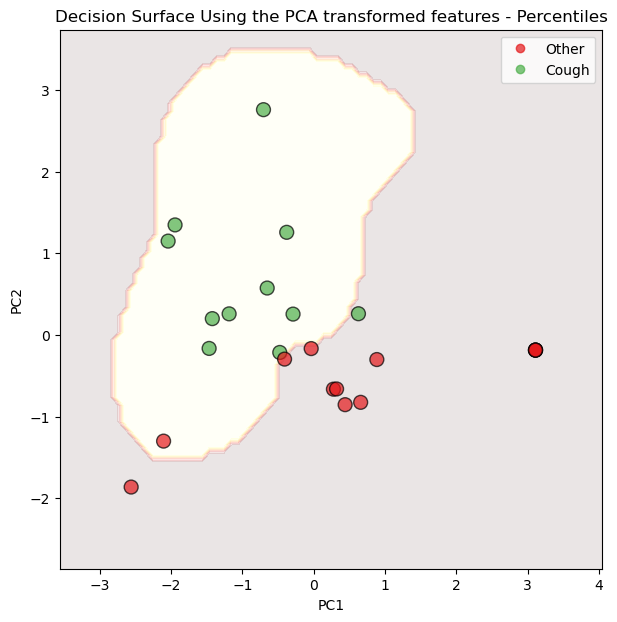

In [244]:
from matplotlib.colors import ListedColormap 

# Prediction
clf_svm_per= SVC(random_state=42, C=100, gamma=1)
clf_svm_per.fit(pca_train_scaled, y_train_svm_per)

# Extraction of PC1 and PC2 for test data
X_test_pca = pca.transform(X_test_scaled_per)
test_pc1_coords = X_test_pca[:, 0]
test_pc2_coords = X_test_pca[:, 1]

# Determining the graph boundaries
x_min = test_pc1_coords.min() - 1
x_max = test_pc1_coords.max() + 1

y_min = test_pc2_coords.min() - 1
y_max = test_pc2_coords.max() + 1

xx, yy = np.meshgrid(np.arange(start=x_min, stop=x_max, step=0.1),
                     np.arange(start=y_min, stop=y_max, step=0.1))


# Classify every point in the matrix with the SVM
# Points on one side 1, point on other side 0 
Z = clf_svm_per.predict(np.column_stack((xx.ravel(), yy.ravel())))
Z = Z.reshape(xx.shape)

Z = np.array(Z)



# Plot the decision boundary and scatter plot of data points
cmap = ListedColormap(['#e41a1c', '#4daf4a'])
fig, ax = plt.subplots(figsize=(7,7))
ax.contourf(xx, yy, Z, alpha=0.1)

scatter = ax.scatter(test_pc1_coords, test_pc2_coords, c=y_test_svm_per, cmap=cmap, s=100, edgecolors='k', alpha=0.7)
legend = ax.legend(scatter.legend_elements()[0],
                  scatter.legend_elements()[1],
                  loc="upper right")

legend.get_texts()[0].set_text('Other')
legend.get_texts()[1].set_text('Cough')

ax.set_ylabel("PC2")
ax.set_xlabel("PC1")
ax.set_title("Decision Surface Using the PCA transformed features - Percentiles")
plt.show()

In [288]:
# Support Vector Machine Data Preparation - Percentiles and MFCCs

df_svm = df_3.copy()

X_svm = df_svm.iloc[:, :5]
y_svm = df_svm.iloc[:, 5:6]

X_svm = np.array(df_svm['mfcc'].tolist())

X_train_svm, X_test_svm, y_train_svm, y_test_svm = train_test_split(X_svm, y_svm, random_state= 3, test_size= 0.2)

y_train_svm = np.ravel(y_train_svm)
y_test_svm = np.ravel(y_test_svm)

y_train_svm = (y_train_svm == 'cough').astype(int)
y_test_svm = (y_test_svm == 'cough').astype(int)

X_train_scaled = scale(X_train_svm)
X_test_scaled = scale(X_test_svm)


Kernel used by the SVM: rbf


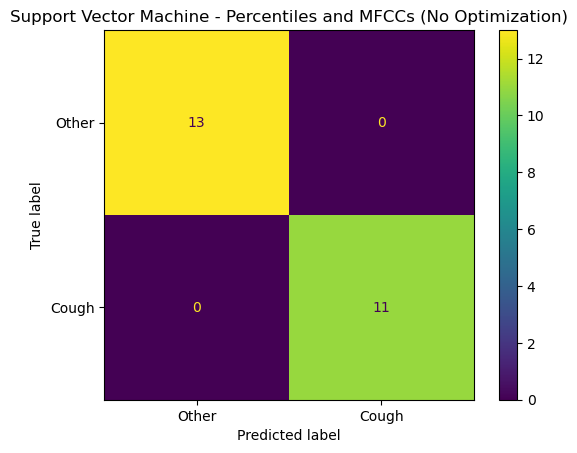

In [280]:
# Support Vector Machine

clf_svm = SVC(random_state=42)
clf_svm.fit(X_train_scaled, y_train_svm)
print("Kernel used by the SVM:", clf_svm.kernel)

y_pred_svm = clf_svm.predict(X_test_scaled)
cm_svm = confusion_matrix(y_test_svm, y_pred_svm)

custom_labels = ['Other', 'Cough']
disp = ConfusionMatrixDisplay(confusion_matrix=cm_svm, display_labels=custom_labels)
disp.plot()
plt.title("Support Vector Machine - Percentiles and MFCCs (No Optimization)")
plt.show()

In [218]:
# Optimize the parameters
# Finding the best value for gamma and regularization parameter

# C: regularization parameter
param_grid = [
    {
    'C': [0.5, 1, 10, 100],
    'gamma': ['scale', 1, 0.1, 0.01, 0.001, 0.0001],
    'kernel': ['rbf']
    },
]

optimal_params = GridSearchCV(
    SVC(),
    param_grid,
    cv=5,
    scoring='accuracy',
    verbose=0
)

optimal_params.fit(X_train_scaled, y_train_svm)
print(optimal_params.best_params_)

{'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}


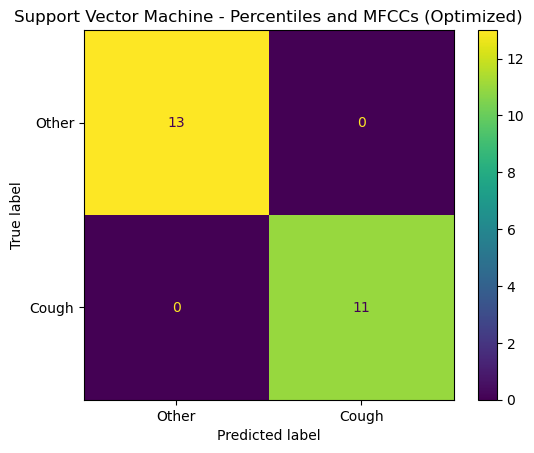

In [281]:
# Final Support Vector Machine

clf_svm_2 = SVC(random_state=42, C=10, gamma=0.0001)
clf_svm_2.fit(X_train_scaled, y_train_svm)

# Plot Confusion Matrix

y_pred_svm_2 = clf_svm_2.predict(X_test_scaled)
cm_svm_2 = confusion_matrix(y_test_svm, y_pred_svm)

custom_labels = ['Other', 'Cough']
disp = ConfusionMatrixDisplay(confusion_matrix=cm_svm_2, display_labels=custom_labels)
disp.plot()
plt.title("Support Vector Machine - Percentiles and MFCCs (Optimized)")
plt.show()